Populating the interactive namespace from numpy and matplotlib
          PL Intensity (kCts/s)
Time (s)                       
0.01                       36.9
0.02                       34.9
0.03                       36.9
0.04                       37.5
0.05                       35.8


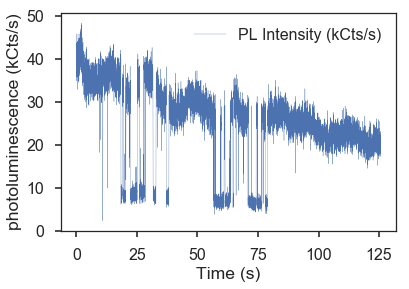

today: 2018-07-01


'O:\\User\\Viva\\analysis\\blinker_analysis\\taken-2018-05-25'

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 17:17:43 2018

Blinker analysis

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
import numpy as np
sns.set(style='ticks')
sns.set_context('poster')

%pylab inline

# ** set for each dataset
datadate = '2018-05-25'
datafolder = r'O:\User\Viva\data\2018-05-25_blinking-statistics'
filename = 'GoodBlinker_5-25-2018.txt'
analysisfolder = r'O:\User\Viva\analysis\blinker_analysis'

os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'
data = pd.read_csv(filename,
                   skiprows=1,
                   header=None,
                   sep='\t',
                   names=['Time (s)','PL Intensity (kCts/s)'],
                   usecols=[0,1])
data = data.set_index(tname)
print(data.head())
rebincount = 0

data.plot(linewidth=0.3)
plt.ylabel('photoluminescence (kCts/s)')
plt.show()

filename = filename.replace('\\','-')
origfilename = filename
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
os.getcwd()

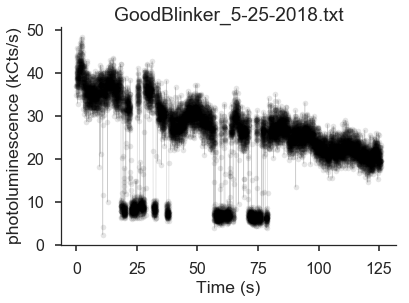

Collection rate: 100.0 Hz
Time bin size: 0.01 sec


In [4]:
fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

sns.despine()
plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

def arangebylength(start, step, length):
    return np.arange(start = start, stop=start+step*(length-.5), step = step )

# rebin: combine two rows into one.
def rebindata(data, colname=PLname, indexname = tname):
    first = 1 # this is a value that indicates if we're on the first (=1) or the second (-1) of a pair of two bins
    rebinvals = []

    for value in data[colname]:
        if first == 1:
            prevval = value
        else:
            # calculate average of the two bins
            combined = (prevval + value) /2.0 
            rebinvals.append(combined)
            del prevval
        first = -1 * first
        
    timesetting = data.index[1]-data.index[0]
    rebintimes = arangebylength(start =0, step = timesetting*2, length = len(rebinvals) )
    rebinneddata = pd.DataFrame(data = rebinvals, index = rebintimes, columns =[colname])
    rebinneddata.index.name=indexname
    return rebinneddata

# The data was collected at a particular rate
timesetting = data.index[1]-data.index[0]
fps = 1/timesetting
print('Collection rate: ' + str(fps) + ' Hz')
print('Time bin size: ' + str(timesetting) + ' sec')

Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec


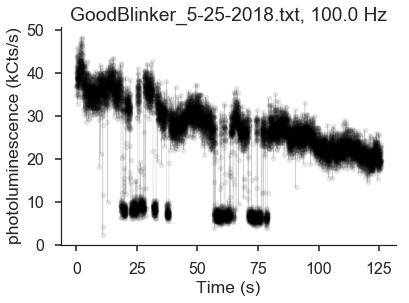

In [5]:
# *** run this an appropriate number of times, can skip if not rebinning

n = 0 # number of times to rebin.

for i in range(n):
    data = rebindata(data)
    rebincount = rebincount + 1
    print(rebincount)

timesetting = data.index[1]-data.index[0]
fps = 1/timesetting
print('Effective collection rate: ' + str(fps) + ' Hz')
print('Time bin size: ' + str(timesetting) + ' sec')
filename = origfilename + ', ' + str(fps) + ' Hz'


fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

sns.despine()
#plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
#plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

93 bins


C:\Users\AlemanLab\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


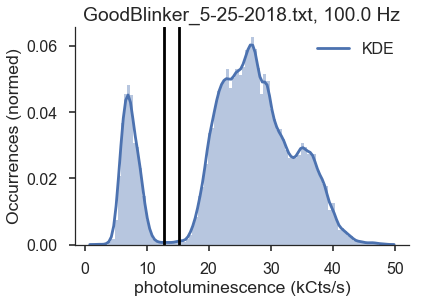

In [6]:
binsequence = np.arange(data.min(), data.max(), fps/200)# ** adjust bins as needed. Higher denominator: more bins
print (str(len(binsequence)) + ' bins')

#data.hist(bins= binsequence)
sns.distplot(data, bins=binsequence, kde=True, rug=False, kde_kws={'bw':.5, 'label':'KDE'}, norm_hist=False);
plt.xlabel('photoluminescence (kCts/s)')
#plt.locator_params(axis='x', nbins=10)
ax = plt.gca()

# ** Need to pick an appropriate threshold between on and off for each dataset
uthreshold = 15.2
lthreshold = uthreshold-2.5

ax.axvline(x=uthreshold, color='k')
ax.axvline(x=lthreshold, color = 'k')
#ax.tick_params(axis='x',which='minor',bottom='on')
#ax.xaxis.set_minor_locator(minorLocator)

plt.title(filename)
plt.ylabel('Occurrences (normed)')
sns.despine()

#plt.savefig(today + ',' + filename+',PLhistogram.pdf', bbox_inches='tight')
#plt.savefig(today + ',' + filename+',PLhistogram.png', bbox_inches='tight', dpi=200)

plt.show()

C:\Users\AlemanLab\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


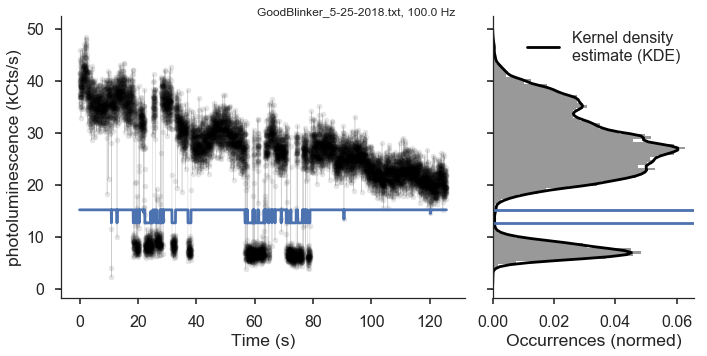

In [8]:
# With an uthreshold and an lthreshold
# This code has an in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either. 
# This seems like the most straightforward way to deal with (rare) cases in between.
# Other options are shown.


threshdata = data[PLname].clip(upper=uthreshold, lower=lthreshold)


fig2,[axPL,axhist] = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True, gridspec_kw = {'width_ratios':[4,2]})
data.plot(marker='.',linestyle='None',legend=False, alpha=0.1, ax=axPL, color='k')
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
threshdata.plot(legend=False, ax=axPL)
axPL.set_ylabel('photoluminescence (kCts/s)')
axPL.set_xlabel(tname)
plt.suptitle(filename)
sns.despine()
plt.tight_layout() 

sns.distplot(data, bins=binsequence, kde=True, rug=False, ax=axhist, vertical=True, color='k',
             kde_kws={'bw':.5, 'label':'Kernel density\nestimate (KDE)'});
#axhist.set_xlabel('photoluminescence (kCts/s)')
axhist.set_xlabel('Occurrences (normed)')
axhist.axhline(y=uthreshold)
axhist.axhline(y=lthreshold)

plt.savefig(today + ',' + filename+',blinkingandthreshold.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinkingandthreshold.png', bbox_inches='tight', dpi=200)

plt.show()

In [ ]:
# Main method: in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either.
downtimes2= threshdata[threshdata != uthreshold].index
uptimes2=threshdata[threshdata != lthreshold].index

#print(uptimes2)
#print(downtimes2)

# Alternate option (not used)
uptimes= threshdata[threshdata == uthreshold].index
downtimes=threshdata[threshdata == lthreshold].index

#print(uptimes)
#print(downtimes)

# We can compare the two ways of interpreting blinks.
# There is a discrepancy at about 22 seconds between the two interpretations. 
# It's a matter of whether we consider it stayed off or 
# if we consider that it came up enough to have ended the off blink and began another.
# I tend to think it ended one and began another in this case, so I'm going to use uptimesep2 as my off duration.

# subtracting each time from the last time we had the same state gives the amount of time it was not in that state.
# Therefore the separation between up times is in fact the duration of time off.
uptimesep = uptimes[1:] - uptimes[:-1]
uptimesep2 = uptimes2[1:] - uptimes2[:-1]

"""
plt.plot(uptimes[:-1],uptimesep, '.-')
plt.plot(uptimes2[:-1],uptimesep2, '-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink off (s)')
plt.figure()
data.plot()
plt.show()
"""

# We can compare the two ways of interpreting blinks. It looks like they mostly agree.

downtimesep = downtimes[1:] - downtimes[:-1]
downtimesep2 = downtimes2[1:] - downtimes2[:-1]

"""
plt.plot(downtimes[:-1],downtimesep,'.-')
plt.plot(downtimes2[:-1],downtimesep2,'-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink on (s)')
#plt.figure()
data.plot()
plt.show()
"""

# I chose to use downtimesep2 and uptimesep2, as detailed above.

ontimes = filter(lambda a: a > 1.5*timesetting, downtimesep2)
offtimes = filter(lambda a: a > 1.5*timesetting, uptimesep2)

# save analyzed data: bright state duration
ontimesdf = pd.DataFrame(ontimes, columns=["Bright state duration (s)"])
ontimesdf.to_csv(filename+' uptimes.csv', index=False, header=True)
print('Uptimes saved to: ')
print(os.path.join(os.getcwd(), filename+ ' uptimes.csv'))
# save analyzed data: dim state duration
offtimesdf = pd.DataFrame(offtimes, columns=["Dim state duration (s)"])
offtimesdf.to_csv(filename+' downtimes.csv', index=False, header=True)
print('Downtimes saved to: ')
print(os.path.join(os.getcwd(), filename+ ' downtimes.csv'))
## to open: 
# ontimesdf = pd.read_csv(filename+' ontimes.csv'
# offtimesdf = pd.read_csv(filename+' downtimes.csv')
#  # convert to list or else the rest of the code won't work.
# ontimes = list(ontimesdf['Bright state duration (s)'])
# offtimes = list(offtimesdf["Dim state duration (s)"])

## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

In [ ]:
# ** Choose a nice number of bins to see how the data look.
# It's better to have as many bins as possible before the first empty bin.

numonbins = 60
numoffbins = 60

#plt.hist(ontimes, bins=numonbins, histtype='step', linewidth=1)
sns.distplot(ontimes, bins=numonbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()
#plt.hist(offtimes, bins=numoffbins, histtype='step', linewidth=1)
sns.distplot(offtimes, bins=numoffbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()

In [ ]:
# I want to have logarithmic bins.

onbins=np.logspace(np.log10(1e-2),np.log10(5), 50)
offbins = np.logspace(np.log10(1e-2),np.log10(5), 50)

#plt.hist(ontimes, bins=numonbins, histtype='step', linewidth=1)
sns.distplot(ontimes, bins=onbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()
#plt.hist(offtimes, bins=numoffbins, histtype='step', linewidth=1)
sns.distplot(offtimes, bins=offbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()

In [8]:
## I decided to start my bins at 0. 
# This might be different from the built in hist function.

oninc = max(ontimes)/numonbins
onbins= frange(min(ontimes),max(ontimes)+oninc*3,oninc)
#print(onbins[0:5])


offinc = max(offtimes)/numoffbins

"""
offbins=np.linspace(min(offtimes),max(offtimes),numoffbins+1)
print("linspace option (not used):")
print(offbins)
offbins= frange(min(offtimes),max(offtimes),offinc)
print("frange approach:")
print(offbins)
#print(offbins[0:5])
"""

offbins= frange(min(offtimes),max(offtimes)+offinc*3,offinc)
print("frange approach and pad 3 bins to right (used):")
print(offbins)

centeredonbins = frange(min(ontimes)+oninc/2,max(ontimes)+oninc*3+oninc/2,oninc)
centeredoffbins= frange(min(offtimes)+offinc/2,max(offtimes)+offinc*3+offinc/2,offinc)
#centeredoffbins=np.linspace(offinc/2,max(offtimes)+offinc/2,numoffbins)

"""
print('\n')
print(onbins[-5:])
print(centeredonbins[-5:])


print("Make sure ")
print(len(centeredonbins))
print(len(onbins))
print(len(centeredoffbins))
print(len(offbins))
"""

frange approach and pad 3 bins to right (used):
[0.019999999999996021, 0.052999999999996029, 0.085999999999996038, 0.11899999999999605, 0.15199999999999605, 0.18499999999999606, 0.21799999999999609, 0.25099999999999612, 0.28399999999999609, 0.31699999999999612, 0.34999999999999609, 0.38299999999999612, 0.41599999999999615, 0.44899999999999612, 0.48199999999999615, 0.51499999999999613, 0.54799999999999616, 0.58099999999999619, 0.61399999999999622, 0.64699999999999613, 0.67999999999999616, 0.71299999999999619, 0.74599999999999622, 0.77899999999999625, 0.81199999999999628, 0.8449999999999962, 0.87799999999999623, 0.91099999999999626, 0.94399999999999629, 0.97699999999999632, 1.0099999999999962, 1.0429999999999964, 1.0759999999999963, 1.1089999999999962, 1.1419999999999964, 1.1749999999999963, 1.2079999999999964, 1.2409999999999963, 1.2739999999999962, 1.3069999999999964, 1.3399999999999963, 1.3729999999999964, 1.4059999999999964, 1.4389999999999963, 1.4719999999999964, 1.5049999999999963,

'\nprint(\'\n\')\nprint(onbins[-5:])\nprint(centeredonbins[-5:])\n\n\nprint("Make sure ")\nprint(len(centeredonbins))\nprint(len(onbins))\nprint(len(centeredoffbins))\nprint(len(offbins))\n'

In [9]:
onhist = histc(ontimes, np.asarray(onbins))
offhist = histc(offtimes, np.asarray(offbins))

red data are histogram data and black data are shifted to be centered on the bin


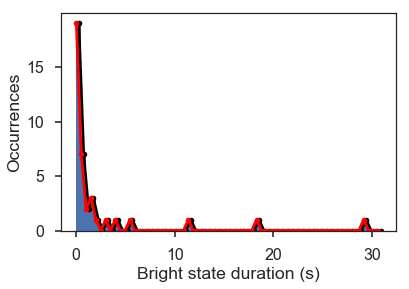

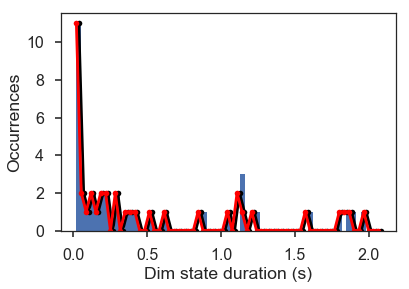

In [10]:
print("red data are histogram data and black data are shifted to be centered on the bin")

#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-k')
ax1.plot(onbins,onhist[0],'.-r')
plt.hist(ontimes, bins=numonbins)
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)

# Apparently my digitize and the hist function don't quite give the same output. 
# I think the hist command doesn't start at zero.
# Either way is probably fine.

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-k')
ax2.plot(offbins,offhist[0],'.-r')
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax2.set_yscale('symlog', linthreshy=1)
plt.show()

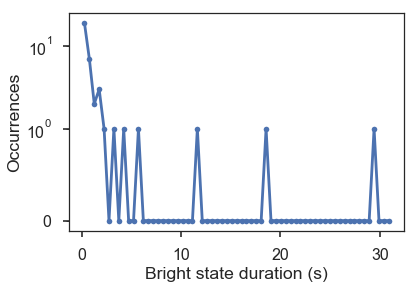

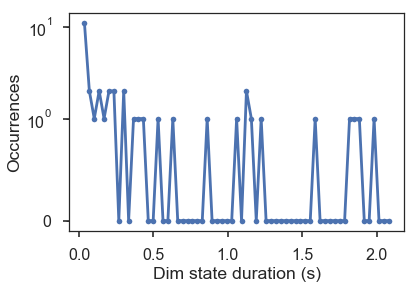

In [11]:
#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax2.set_yscale('symlog', linthreshy=1)
plt.show()

In [12]:
from scipy.optimize import curve_fit
import scipy
print(scipy.__version__)
# need at least version 14.0 of scipy.

def expfit(t, A, tau):
    return (A * np.exp(t/(-tau)))

def powlaw(t, C, m):
    return C * t**(-m)

# Trying to find good guess
#onparamexp[1]=-.8
#onfitexp = 30 * np.exp(centeredonbins/(onparamexp[1]))

0.17.1


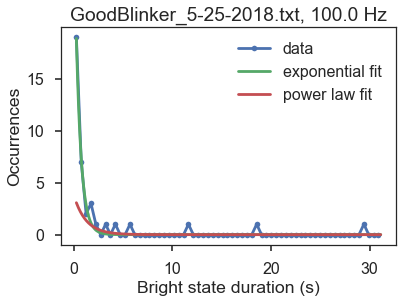

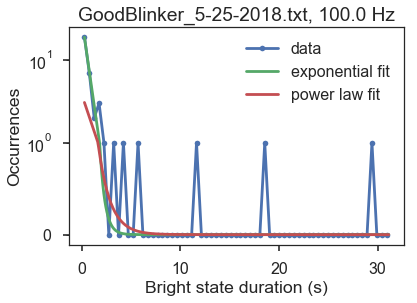

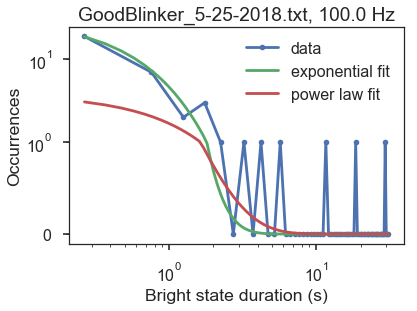

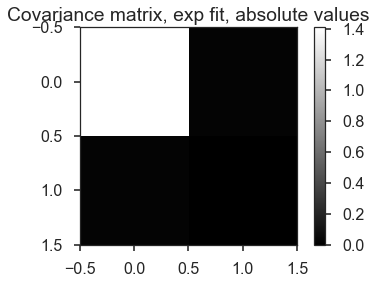

It's ok to use the uncertainties below as long as there aren't strong diagonal values.


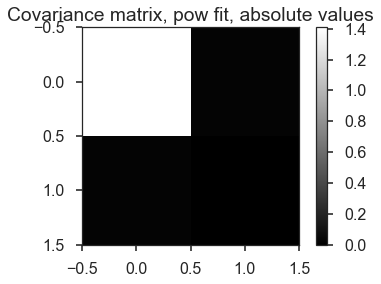

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Exponential fit:
On Coefficient A_up = 31.3613747392 ± 1.18751283034
time constant tau_up = 0.524972298115 ± 0.0247155301917 sec
Power law:
On Coefficient C_up = 3.81347130556 ± 0.202394691611
logarithmic slope m_up = 1.22667368057 ± 0.0420907254456


In [13]:
# Create lists
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy   
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

onfitx = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)

# on time exponential fit, not truncated
onparamexp, onpcovexp = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = (30, 0.8))
onfitexp = expfit(onfitx,onparamexp[0],onparamexp[1])

# on time power law fit, not truncated
onparampow, onpcovpow = curve_fit(powlaw, centeredonbinstrunc, onhistl,p0 = (.6, 2))
onfitpow = expfit(onfitx,onparampow[0],onparampow[1])


fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
ax1.set_xscale('log')
plt.show()

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

print 'Exponential fit:'
print  'On Coefficient A_up = ' + str(onparamexp[0]) + ' ± ' + str(np.sqrt(onpcovexp[0,0]))
print 'time constant tau_up = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'On Coefficient C_up = ' + str(onparampow[0]) + ' ± ' + str(np.sqrt(onpcovpow[0,0]))
print 'logarithmic slope m_up = ' + str(onparampow[1]) + ' ± ' + str(np.sqrt(onpcovpow[1,1]))


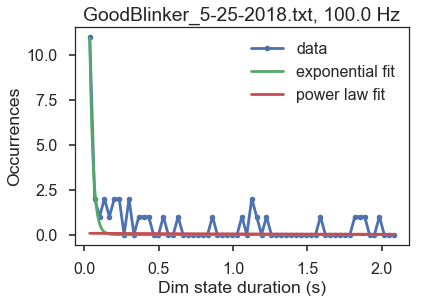

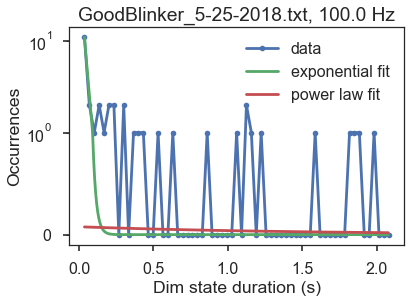

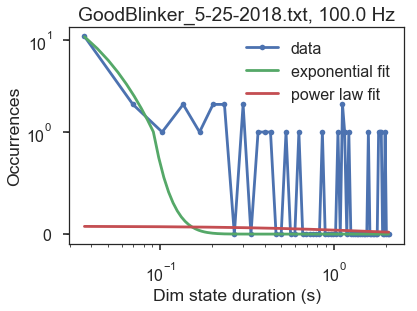

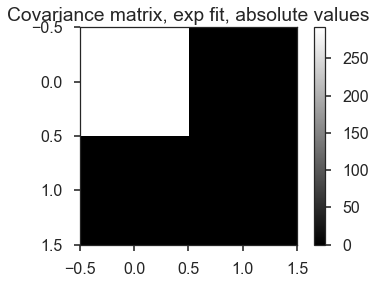

It's ok to use the uncertainties below as long as there aren't strong diagonal values.


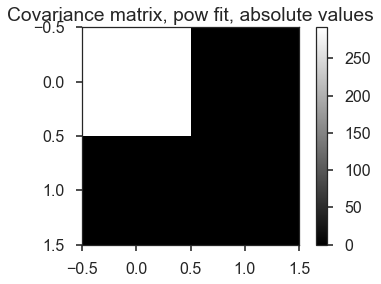

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Exponential fit:
off Coefficient A_dim = 53.5629977099 ± 17.0862996444
time constant tau_dim = 0.0229410898193 ± 0.00426708106667 sec
Power law:
off Coefficient C_dim = 0.0772108162567 ± 0.0323290225677
logarithmic slope m_dim = 1.47940410295 ± 0.132911085763


In [14]:
showpowfit = True

offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)

# off time exponential fit
offparamexp, offpcovexp = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = (30, 0.8))
offfitexp = expfit(offfitx,offparamexp[0],offparamexp[1])

# off time power law fit
offparampow, offpcovpow = curve_fit(powlaw, centeredoffbinstrunc, offhistl,p0 = (.6, 2))
offfitpow = expfit(offfitx,offparampow[0],offparampow[1])

# display
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
ax1.set_xscale('log')
plt.show()

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

print 'Exponential fit:'
print  'off Coefficient A_dim = ' + str(offparamexp[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'off Coefficient C_dim = ' + str(offparampow[0]) + ' ± ' + str(np.sqrt(offpcovpow[0,0]))
print 'logarithmic slope m_dim = ' + str(offparampow[1]) + ' ± ' + str(np.sqrt(offpcovpow[1,1]))


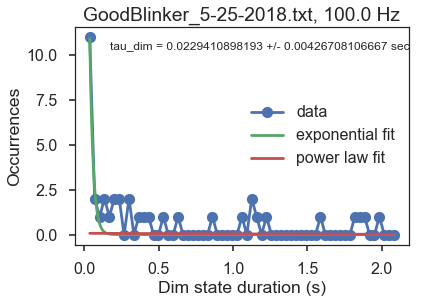

In [15]:
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label="exponential fit")
if showpowfit:
    ax1.plot(offfitx,offfitpow, label='power law fit')
plt.text(1.0,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename) 
plt.legend(loc=5)

plt.show()

In [16]:
#basefilename = today + ',' + filename+',offblinks' + infostr

def ploteveryfig(fig,ax,basefilename,fitx,powfit, save=True):
    sns.despine()
    
  #  fig.savefig(basefilename + '.pdf', bbox_inches='tight', dpi=200)
  #  fig.savefig(basefilename + '.png', bbox_inches='tight', dpi=200)

  #  ax.set_yscale('symlog', linthreshy=1)
  #  fig.savefig(basefilename + ',semisymlog.pdf', bbox_inches='tight', dpi=200)
  #  fig.savefig(basefilename + ',semisymlog.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('linear')
    ax.plot(fitx, powfit, label="power law")
    ax.legend(loc=5)
    if save:
        fig.savefig(basefilename + ',powfit.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('symlog', linthreshy=1)
    ax.legend(loc=3)
    if save:
        fig.savefig(basefilename + ',powfit,semisymlog.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit,semisymlog.png', bbox_inches='tight', dpi=200)

    ax.set_xscale('log')
    if save:
        fig.savefig(basefilename + ',powfit,symloglog.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit,symloglog.png', bbox_inches='tight', dpi=200)
    

dim time constant tau_dim = 0.0229410898193 ± 0.00426708106667 sec
bright time constant tau = 0.524972298115 ± 0.0247155301917 sec


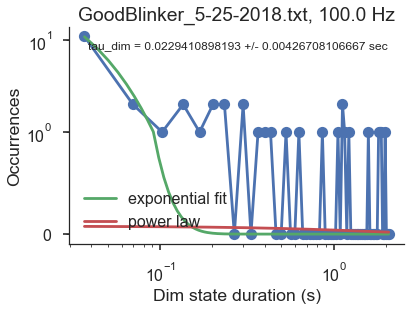

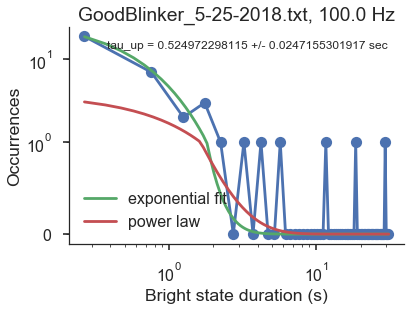

In [17]:
# Save figures

# mpl.rcParams['figure.dpi'] = 200

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ',fitpast0'

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label="exponential fit")
plt.text(0.95,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',offblinks' + infostr,offfitx,offfitpow, save=False)

print 'dim time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'


# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
plt.text(0.95,0.9,'tau_up = '  + str(onparamexp[1]) + ' +/- '  + str(np.sqrt(onpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',onblinks' + infostr,onfitx,onfitpow, save=False)

print 'bright time constant tau = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'


plt.show()


In [18]:
#mpl.rcParams.update(mpl.rcParamsDefault)
#sns.set(style='ticks')
#sns.set_context('poster')

In [19]:
# reset in case I've already run this.
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

# cut off data above zero bin
zeroindexon = onhistl.index(0)
del onhistl[zeroindexon:]
del centeredonbinstrunc[zeroindexon:]
zeroindexoff = offhistl.index(0)
del offhistl[zeroindexoff:]
del centeredoffbinstrunc[zeroindexoff:]
    
infostr = ''

try:
    guessonparamexp = onparamexp
except:
    guessonparamexp=(30,0.8)
print('Guessing: ' + str(guessonparamexp))    
    
try:
    guessoffparamexp = offparamexp
except:
    guessoffparamexp = (30,0.8)
print('Guessing: ' + str(guessoffparamexp))

try:
    guessonparampow = onparampow
except:
    guessonparampow = (30,1)
print('Guessing: ' + str(guessonparampow))

try:
    guessoffparampow = offparampow
except:
    guessoffparampow = (30,1)
print('Guessing: ' + str(guessoffparampow))

Guessing: [ 31.36137474   0.5249723 ]
Guessing: [  5.35629977e+01   2.29410898e-02]
Guessing: [ 3.81347131  1.22667368]
Guessing: [ 0.07721082  1.4794041 ]


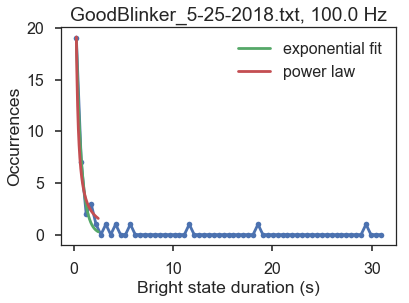

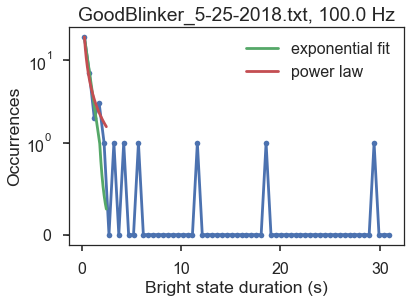

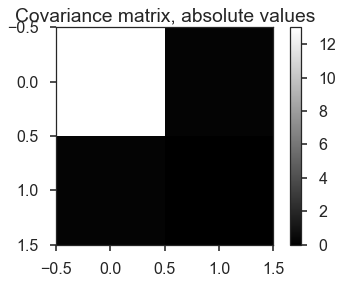

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 31.4466648951 ± 3.60932327077
time constant tau_up = 0.522795647467 ± 0.0746605140847 sec


In [20]:
# on time fit, truncated

onfitxtrunc = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)

# exponential fit
onparamexptrunc, onpcovexp = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = guessonparamexp)
onfitexptrunc = expfit(onfitxtrunc,onparamexptrunc[0],onparamexptrunc[1])

# power law fit
onparampowtrunc, onpcovpow = curve_fit(powlaw, centeredonbinstrunc, onhistl,p0 = guessonparampow)
onfitpowtrunc = powlaw(onfitxtrunc,onparampowtrunc[0],onparampowtrunc[1])

# display the fit
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential fit")
if showpowfit:
    ax1.plot(onfitxtrunc, onfitpowtrunc, label="power law")
    plt.legend()
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog',linthreshy=1)
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential fit")
if showpowfit:
    ax1.plot(onfitxtrunc, onfitpowtrunc, label="power law")
    plt.legend()
plt.title(filename)
plt.show()

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(onparamexptrunc[0]) + ' ± ' + str(np.sqrt(onpcovexp[0,0]))
print 'time constant tau_up = ' + str(onparamexptrunc[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'



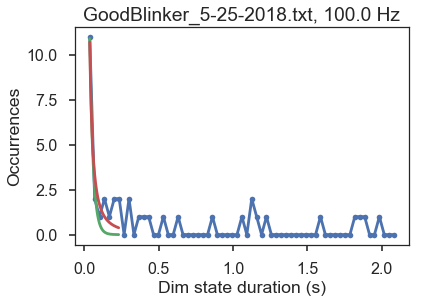

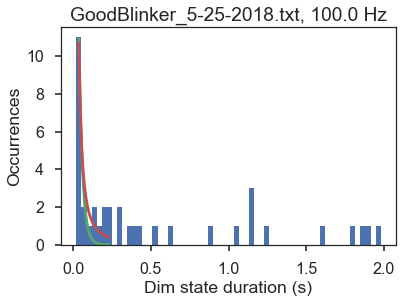

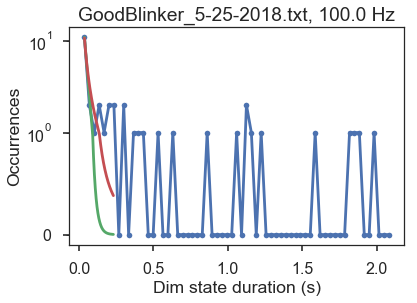

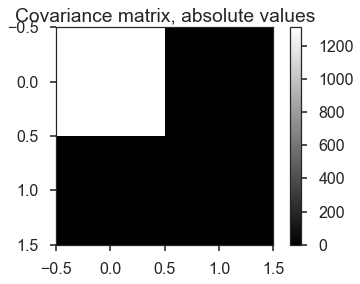

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 53.5856383973 ± 36.2528607049
time constant tau = 0.0229352849846 ± 0.00904570762071 sec
Exponential fit, truncated:
off Coefficient A_dim = 53.5856383973 ± 36.2528607049
time constant tau_dim = 0.0229352849846 ± 0.00904570762071 sec
Power law fit, truncated:
off Coefficient C_dim = 0.0271007795658 ± 0.0352007931316
logarithmic slope m_dim = 1.80638196707 ± 0.402619446681


In [21]:
# off time fit, truncated

offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)

# exponential fit
offparamexptrunc, offpcovexp = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = guessoffparamexp)
offfitexptrunc = expfit(offfitx,offparamexptrunc[0],offparamexptrunc[1])

# power law fit
offparampowtrunc, offpcovpow = curve_fit(powlaw, centeredoffbinstrunc, offhistl,p0 = guessoffparampow)
offfitpowtrunc = powlaw(offfitx,offparampowtrunc[0],offparampowtrunc[1])

# display the fit
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(offparamexptrunc[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau = ' + str(offparamexptrunc[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Exponential fit, truncated:'
print  'off Coefficient A_dim = ' + str(offparamexptrunc[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau_dim = ' + str(offparamexptrunc[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Power law fit, truncated:'
print  'off Coefficient C_dim = ' + str(offparampowtrunc[0]) + ' ± ' + str(np.sqrt(offpcovpow[0,0]))
print 'logarithmic slope m_dim = ' + str(offparampowtrunc[1]) + ' ± ' + str(np.sqrt(offpcovpow[1,1]))

dim time constant tau = 0.0229410898193 ± 0.00904570762071 sec
m_dim = 1.80638196707 +/- 0.402619446681
bright time constant tau_up = 0.524972298115 ± 0.0746605140847 sec
m_up = 1.22667368057 ± 0.126355117935


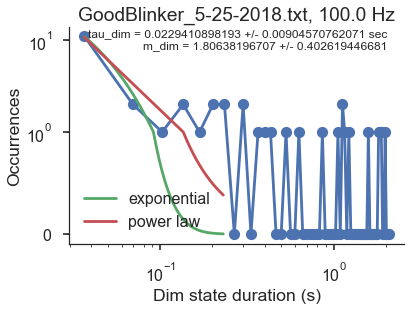

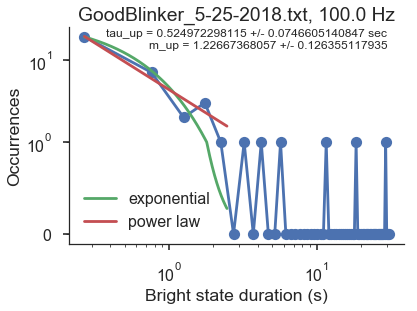

In [22]:
# Save figures, truncated fits

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ''

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
plt.text(0.95,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) 
         + ' sec\nm_dim = ' + str(offparampowtrunc[1]) + ' +/- ' + str(np.sqrt(offpcovpow[1,1])),
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',offblinks' + infostr,offfitx,offfitpowtrunc)


print 'dim time constant tau = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'
print('m_dim = ' + str(offparampowtrunc[1]) + ' +/- ' + str(np.sqrt(offpcovpow[1,1])))

# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential")
plt.text(0.95,0.9,'tau_up = '  + str(onparamexp[1]) + ' +/- '  + str(np.sqrt(onpcovexp[1,1])) + ' sec\n'
         +'m_up = ' + str(onparampow[1]) + ' +/- ' + str(np.sqrt(onpcovpow[1,1])),
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',onblinks' + infostr,onfitxtrunc,onfitpowtrunc)

print 'bright time constant tau_up = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'
print 'm_up = ' + str(onparampow[1]) + ' ± ' + str(np.sqrt(onpcovpow[1,1])) 


plt.show()

In [23]:
print 'Exp [A, tau]'
print offparamexp
print onparamexp

print 'Pow [C, m]'
print offparampow
print onparampow

print '\n'

print 'With truncation (ignore first empty bin and all following bins)'
print 'Exp [A, tau]'
print offparamexptrunc
print onparamexptrunc

print 'Pow [C, m]'
print offparampowtrunc
print onparampowtrunc

Exp [A, tau]
[  5.35629977e+01   2.29410898e-02]
[ 31.36137474   0.5249723 ]
Pow [C, m]
[ 0.07721082  1.4794041 ]
[ 3.81347131  1.22667368]


With truncation (ignore first empty bin and all following bins)
Exp [A, tau]
[  5.35856384e+01   2.29352850e-02]
[ 31.4466649    0.52279565]
Pow [C, m]
[ 0.02710078  1.80638197]
[ 4.33522689  1.12397922]
